In [1]:
import pandas as pd 

In [4]:
!pip install numpy tensorflow torch torchvision matplotlib scikit-learn  

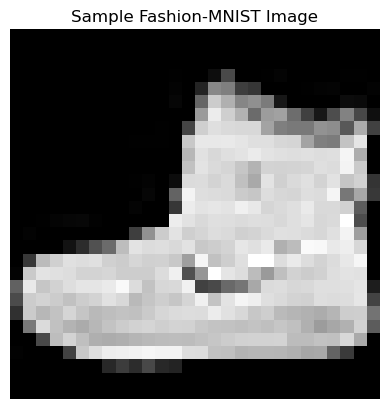

In [12]:
import numpy as np  
import tensorflow as tf  
from tensorflow.keras.datasets import fashion_mnist  
import matplotlib.pyplot as plt  

# Load the Fashion-MNIST dataset  
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()  

# Preprocess the dataset  
def preprocess_images(images):  
    # Convert to float32 and normalize to [0,1]  
    images = images.astype('float32') / 255.0  
    return images.reshape(-1, 28, 28)  # Reshape to 28x28  

# Apply preprocessing  
x_train_processed = preprocess_images(x_train)  
x_test_processed = preprocess_images(x_test)  

# Binarize images (for RBM training)  
x_train_binarized = (x_train_processed > 0.5).astype(np.float32)  
x_test_binarized = (x_test_processed > 0.5).astype(np.float32)  

# Display the first image in the training set  
plt.imshow(x_train_processed[0], cmap='gray')  
plt.title('Sample Fashion-MNIST Image')  
plt.axis('off')  
plt.show()  

Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


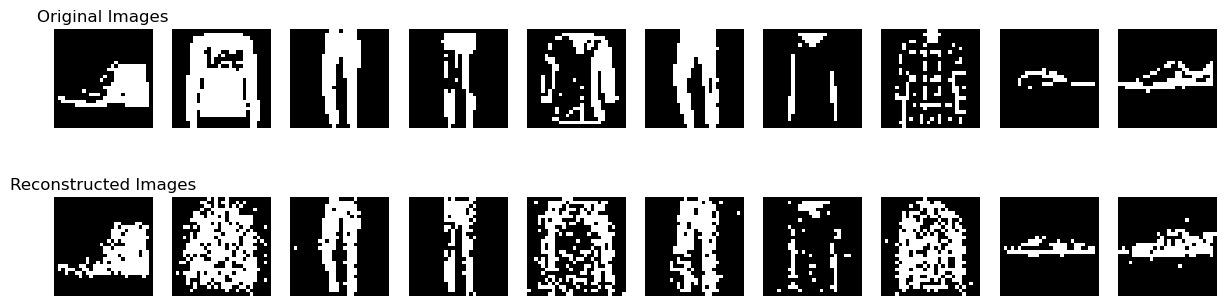

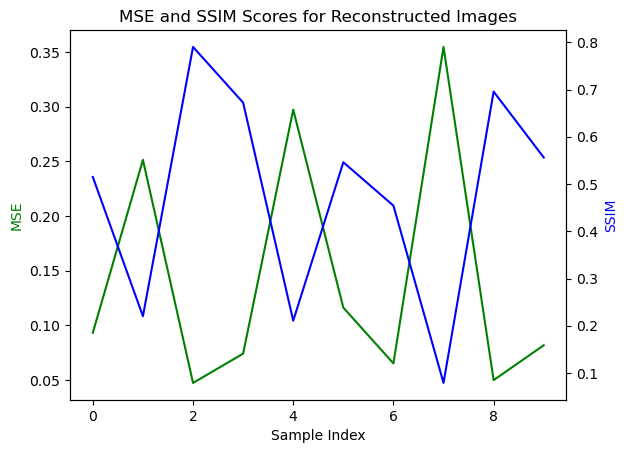

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Define the RBM class
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, k=1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.k = k  # Number of Gibbs Sampling steps
        
        # Initialize weights and biases
        self.W = tf.Variable(tf.random.normal([visible_units, hidden_units], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([hidden_units]))
        self.v_bias = tf.Variable(tf.zeros([visible_units]))

    def sample_hidden(self, v):
        """ Sample hidden units given visible units """
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))  # Binary sampling

    def sample_visible(self, h):
        """ Sample visible units given hidden units """
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))  # Binary sampling
    
    def contrastive_divergence(self, v0):
        """ Perform CD-k """
        h0 = self.sample_hidden(v0)
        v_sample = v0
        
        for _ in range(self.k):
            h_sample = self.sample_hidden(v_sample)
            v_sample = self.sample_visible(h_sample)
        
        h_sample = self.sample_hidden(v_sample)
        
        # Compute weight updates
        positive_phase = tf.matmul(tf.transpose(v0), h0)
        negative_phase = tf.matmul(tf.transpose(v_sample), h_sample)
        
        self.W.assign_add(self.learning_rate * (positive_phase - negative_phase))
        self.v_bias.assign_add(self.learning_rate * tf.reduce_mean(v0 - v_sample, axis=0))
        self.h_bias.assign_add(self.learning_rate * tf.reduce_mean(h0 - h_sample, axis=0))

    def train(self, data, epochs=10, batch_size=100):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.contrastive_divergence(batch)
            print(f"Epoch {epoch + 1}/{epochs} completed")
    
    def transform(self, data):
        """ Extract features from data using trained RBM """
        return tf.nn.sigmoid(tf.matmul(data, self.W) + self.h_bias)

# Load and preprocess Fashion-MNIST dataset
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0  # Normalize to [0,1]
    return images.reshape(-1, 28 * 28)  # Flatten images

x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

# Binarize images (for RBM training)
x_train_binarized = (x_train_processed > 0.5).astype(np.float32)
x_test_binarized = (x_test_processed > 0.5).astype(np.float32)

# Initialize and train the RBM
rbm = RBM(visible_units=28 * 28, hidden_units=128, learning_rate=0.01, k=1)
rbm.train(x_train_binarized, epochs=10, batch_size=100)

# Extract features
train_features = rbm.transform(x_train_binarized)
test_features = rbm.transform(x_test_binarized)

# Compute reconstruction error (MSE and SSIM)
def compute_metrics(original, rbm):
    hidden_representation = rbm.sample_hidden(original)
    reconstructed = rbm.sample_visible(hidden_representation)
    
    mse = mean_squared_error(original.numpy().flatten(), reconstructed.numpy().flatten())
    ssim_score = ssim(original.numpy().reshape(28, 28), reconstructed.numpy().reshape(28, 28), data_range=1.0)
    return mse, ssim_score, reconstructed

# Compute errors for a batch
mse_errors = []
ssim_scores = []
sample_images = x_test_binarized[:10]
reconstructed_images = []

for img in sample_images:
    mse, ssim_score, reconstructed = compute_metrics(tf.expand_dims(img, 0), rbm)
    mse_errors.append(mse)
    ssim_scores.append(ssim_score)
    reconstructed_images.append(reconstructed.numpy().reshape(28, 28))

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(sample_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis("off")
axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")
plt.show()

# Plot MSE and SSIM comparison
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(len(mse_errors)), mse_errors, 'g-')
ax2.plot(range(len(ssim_scores)), ssim_scores, 'b-')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('MSE', color='g')
ax2.set_ylabel('SSIM', color='b')
plt.title("MSE and SSIM Scores for Reconstructed Images")
plt.show()


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Define the RBM class
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, k=1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.k = k  # Number of Gibbs Sampling steps
        
        # Initialize weights and biases
        self.W = tf.Variable(tf.random.normal([visible_units, hidden_units], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([hidden_units]))
        self.v_bias = tf.Variable(tf.zeros([visible_units]))

    def sample_hidden(self, v):
        """ Sample hidden units given visible units """
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))  # Binary sampling

    def sample_visible(self, h):
        """ Sample visible units given hidden units """
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))  # Binary sampling
    
    def contrastive_divergence(self, v0):
        """ Perform CD-k """
        h0 = self.sample_hidden(v0)
        v_sample = v0
        
        for _ in range(self.k):
            h_sample = self.sample_hidden(v_sample)
            v_sample = self.sample_visible(h_sample)
        
        h_sample = self.sample_hidden(v_sample)
        
        # Compute weight updates
        positive_phase = tf.matmul(tf.transpose(v0), h0)
        negative_phase = tf.matmul(tf.transpose(v_sample), h_sample)
        
        self.W.assign_add(self.learning_rate * (positive_phase - negative_phase))
        self.v_bias.assign_add(self.learning_rate * tf.reduce_mean(v0 - v_sample, axis=0))
        self.h_bias.assign_add(self.learning_rate * tf.reduce_mean(h0 - h_sample, axis=0))

    def train(self, data, epochs=10, batch_size=100):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.contrastive_divergence(batch)
            print(f"Epoch {epoch + 1}/{epochs} completed")
    
    def transform(self, data):
        """ Extract features from data using trained RBM """
        return tf.nn.sigmoid(tf.matmul(data, self.W) + self.h_bias)

# Load and preprocess Fashion-MNIST dataset
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0  # Normalize to [0,1]
    return images.reshape(-1, 28 * 28)  # Flatten images

x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

# Binarize images (for RBM training)
x_train_binarized = (x_train_processed > 0.5).astype(np.float32)
x_test_binarized = (x_test_processed > 0.5).astype(np.float32)

# Initialize and train the RBM
rbm = RBM(visible_units=28 * 28, hidden_units=128, learning_rate=0.01, k=1)
rbm.train(x_train_binarized, epochs=10, batch_size=100)

# Extract features
test_features = rbm.transform(x_test_binarized)

# Compute reconstruction error (MSE and SSIM)
def compute_metrics(original, rbm):
    hidden_representation = rbm.sample_hidden(original)
    reconstructed = rbm.sample_visible(hidden_representation).numpy()  # Convert Tensor to NumPy
    
    mse = mean_squared_error(original.numpy().flatten(), reconstructed.flatten())
    ssim_score = ssim(original.numpy().reshape(28, 28), reconstructed.reshape(28, 28), data_range=1.0)
    
    # Compute number of changed pixels
    changed_pixels = np.sum(original.numpy().astype(int).flatten() != reconstructed.astype(int).flatten())
    
    return mse, ssim_score, changed_pixels

# Compute errors for a batch
sample_images = x_test_binarized[:10]
for idx, img in enumerate(sample_images):
    mse, ssim_score, changed_pixels = compute_metrics(tf.expand_dims(img, 0), rbm)
    print(f"Image {idx + 1}:")
    print(f"  - Mean Squared Error (MSE): {mse:.4f}")
    print(f"  - Structural Similarity Index (SSIM): {ssim_score:.4f}")
    print(f"  - Change in Pixel Values: {changed_pixels} pixels modified")
    print("---------------------------------------------------")


Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed
Image 1:
  - Mean Squared Error (MSE): 0.1237
  - Structural Similarity Index (SSIM): 0.3987
  - Change in Pixel Values: 97 pixels modified
---------------------------------------------------
Image 2:
  - Mean Squared Error (MSE): 0.2181
  - Structural Similarity Index (SSIM): 0.2848
  - Change in Pixel Values: 171 pixels modified
---------------------------------------------------
Image 3:
  - Mean Squared Error (MSE): 0.0536
  - Structural Similarity Index (SSIM): 0.7910
  - Change in Pixel Values: 42 pixels modified
---------------------------------------------------
Image 4:
  - Mean Squared Error (MSE): 0.0599
  - Structural Similarity Index (SSIM): 0.7464
  - Change in Pixel Values: 47 pixels modified
---------------------------------------------------
Image 5:
  - Mean Sq

In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the Generator
def build_generator(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
        tf.keras.layers.Reshape((28, 28))
    ])
    return model

# Define the Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Ensure train_features is a NumPy array (Extracted RBM hidden activations)
if 'train_features' not in globals():
    raise ValueError("train_features is not defined. Ensure RBM features are computed.")

# Initialize models
generator = build_generator(input_dim=train_features.shape[1])  # Match RBM hidden size
discriminator = build_discriminator()

discriminator.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), 
    metrics=['accuracy']
)

discriminator.trainable = False  # Freeze discriminator for GAN training

# GAN model (Generator + Discriminator)
gan_input = tf.keras.layers.Input(shape=(train_features.shape[1],))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Training function
def train_gan(epochs=10000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, train_features.shape[0], batch_size)
        real_images = x_train_binarized[idx]  # Fetch real images
        rbm_features = train_features[idx]  # Fetch corresponding RBM features
        
        generated_images = generator.predict(rbm_features, verbose=0)  # Generate fake images

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average loss

        # Train generator (fool discriminator)
        g_loss = gan.train_on_batch(rbm_features, np.ones((batch_size, 1)))

        # Print progress every 1000 epochs
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]:.2f}, G Loss: {g_loss:.4f}")

# Start Training
train_gan(epochs=10000, batch_size=64)

# Generate and visualize images
rbm_sample = train_features[:10]  # Select first 10 RBM feature samples
generated_images = generator.predict(rbm_sample, verbose=0)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis("off")
plt.suptitle("Generated Images from RBM Features")
plt.show()


TypeError: unsupported format string passed to list.__format__

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from skimage.metrics import structural_similarity as ssim

# ================================
# Step 1: Define the RBM Model
# ================================
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, k=1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.k = k  # Number of Gibbs Sampling steps
        
        # Initialize weights and biases
        self.W = tf.Variable(tf.random.normal([visible_units, hidden_units], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([hidden_units]))
        self.v_bias = tf.Variable(tf.zeros([visible_units]))

    def sample_hidden(self, v):
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return tf.cast(tf.random.uniform(tf.shape(h_prob)) < h_prob, dtype=tf.float32)  # Binary sampling

    def sample_visible(self, h):
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return tf.cast(tf.random.uniform(tf.shape(v_prob)) < v_prob, dtype=tf.float32)  # Binary sampling
    
    def contrastive_divergence(self, v0):
        h0 = self.sample_hidden(v0)
        v_sample = v0
        
        for _ in range(self.k):
            h_sample = self.sample_hidden(v_sample)
            v_sample = self.sample_visible(h_sample)
        
        h_sample = self.sample_hidden(v_sample)
        
        positive_phase = tf.matmul(tf.transpose(v0), h0)
        negative_phase = tf.matmul(tf.transpose(v_sample), h_sample)
        
        self.W.assign_add(self.learning_rate * (positive_phase - negative_phase))
        self.v_bias.assign_add(self.learning_rate * tf.reduce_mean(v0 - v_sample, axis=0))
        self.h_bias.assign_add(self.learning_rate * tf.reduce_mean(h0 - h_sample, axis=0))

    def train(self, data, epochs=10, batch_size=100):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.contrastive_divergence(batch)
            print(f"Epoch {epoch + 1}/{epochs} completed")
    
    def transform(self, data):
        return tf.nn.sigmoid(tf.matmul(data, self.W) + self.h_bias)

# ================================
# Step 2: Load and Preprocess Data
# ================================
(x_train, _), (x_test, _) = fashion_mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0  # Normalize to [0,1]
    return images.reshape(-1, 28 * 28)  # Flatten images

x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

x_train_binarized = (x_train_processed > 0.5).astype(np.float32)
x_test_binarized = (x_test_processed > 0.5).astype(np.float32)

# ================================
# Step 3: Train the RBM
# ================================
rbm = RBM(visible_units=28 * 28, hidden_units=128, learning_rate=0.01, k=1)
rbm.train(x_train_binarized, epochs=10, batch_size=100)

train_features = rbm.transform(x_train_binarized).numpy()
test_features = rbm.transform(x_test_binarized).numpy()

# ================================
# Step 4: Define GAN Model
# ================================
def build_generator(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
        tf.keras.layers.Reshape((28, 28))
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

generator = build_generator(input_dim=128)
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

gan_input = tf.keras.layers.Input(shape=(128,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# ================================
# Step 5: Train the GAN
# ================================
def train_gan(epochs=10000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, train_features.shape[0], batch_size)
        real_images = x_train_binarized[idx].reshape(batch_size, 28, 28)
        
        rbm_features = train_features[idx]
        generated_images = generator.predict(rbm_features, verbose=0)
        
        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        g_loss = gan.train_on_batch(rbm_features, np.ones((batch_size, 1)))
        
        if epoch % 1000 == 0:
            # Extract scalar values from the loss arrays
            d_loss_value = d_loss[0] if isinstance(d_loss[0], (float, np.floating)) else d_loss[0][0]
            d_acc_value = d_loss[1] if isinstance(d_loss[1], (float, np.floating)) else d_loss[1][0]
            g_loss_value = g_loss[0] if isinstance(g_loss, (list, np.ndarray)) else g_loss
            
            print(f"Epoch {epoch} | D Loss: {d_loss_value:.4f}, D Acc: {d_acc_value:.2f}, G Loss: {g_loss_value:.4f}")

train_gan(epochs=10000, batch_size=64)

# ================================
# Step 6: Generate and Visualize Images
# ================================
rbm_sample = train_features[:10]
generated_images = generator.predict(rbm_sample, verbose=0)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis("off")
plt.suptitle("Generated Images from RBM Features")
plt.show()

Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed
Epoch 0 | D Loss: 0.7063, D Acc: 0.43, G Loss: 0.6265


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

# ================================
# Step 1: Define the RBM Model
# ================================
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, k=1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.k = k  # Gibbs Sampling steps
        
        # Initialize weights and biases
        self.W = tf.Variable(tf.random.normal([visible_units, hidden_units], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([hidden_units]))
        self.v_bias = tf.Variable(tf.zeros([visible_units]))

    def sample_hidden(self, v):
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return tf.cast(tf.random.uniform(tf.shape(h_prob)) < h_prob, dtype=tf.float32)

    def sample_visible(self, h):
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return tf.cast(tf.random.uniform(tf.shape(v_prob)) < v_prob, dtype=tf.float32)
    
    def contrastive_divergence(self, v0):
        h0 = self.sample_hidden(v0)
        v_sample = v0
        
        for _ in range(self.k):
            h_sample = self.sample_hidden(v_sample)
            v_sample = self.sample_visible(h_sample)
        
        h_sample = self.sample_hidden(v_sample)
        
        positive_phase = tf.matmul(tf.transpose(v0), h0)
        negative_phase = tf.matmul(tf.transpose(v_sample), h_sample)
        
        self.W.assign_add(self.learning_rate * (positive_phase - negative_phase))
        self.v_bias.assign_add(self.learning_rate * tf.reduce_mean(v0 - v_sample, axis=0))
        self.h_bias.assign_add(self.learning_rate * tf.reduce_mean(h0 - h_sample, axis=0))

    def train(self, data, epochs=10, batch_size=100):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.contrastive_divergence(batch)
            print(f"Epoch {epoch + 1}/{epochs} completed")
    
    def transform(self, data):
        return tf.nn.sigmoid(tf.matmul(data, self.W) + self.h_bias)

# ================================
# Step 2: Load and Preprocess Data
# ================================
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0  # Normalize to [0,1]
    return images.reshape(-1, 28 * 28)  # Flatten images

x_train_processed = preprocess_images(x_train)
x_train_binarized = (x_train_processed > 0.5).astype(np.float32)

# ================================
# Step 3: Train the RBM
# ================================
rbm = RBM(visible_units=28 * 28, hidden_units=128, learning_rate=0.01, k=1)
rbm.train(x_train_binarized, epochs=10, batch_size=100)

train_features = rbm.transform(x_train_binarized).numpy()

# ================================
# Step 4: Define GAN Model
# ================================
def build_generator(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
        tf.keras.layers.Reshape((28, 28))
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

generator = build_generator(input_dim=128)  # Match RBM hidden size
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

gan_input = tf.keras.layers.Input(shape=(128,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# ================================
# Step 5: Train the GAN
# ================================
def train_gan(epochs=10000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, train_features.shape[0], batch_size)
        real_images = x_train_binarized[idx].reshape(-1, 28, 28)
        rbm_features = train_features[idx]
        generated_images = generator.predict(rbm_features, verbose=0)
        
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = gan.train_on_batch(rbm_features, np.ones((batch_size, 1)))
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]:.2f}, G Loss: {g_loss:.4f}")

train_gan(epochs=10000, batch_size=64)

# ================================
# Step 6: Evaluate Performance
# ================================
def compute_fid(real_images, fake_images):
    real_images = preprocess_input(real_images)
    fake_images = preprocess_input(fake_images)
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
    real_act = model.predict(real_images)
    fake_act = model.predict(fake_images)
    mu1, sigma1 = real_act.mean(axis=0), np.cov(real_act, rowvar=False)
    mu2, sigma2 = fake_act.mean(axis=0), np.cov(fake_act, rowvar=False)
    fid = np.linalg.norm(mu1 - mu2) + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1 @ sigma2))
    return fid
